# Wiki Fraud Detection - Exploratory Data Analysis

This notebook analyzes Wikipedia editor behavior patterns to identify potential fraudulent accounts.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Preparation

In [2]:
# Load features and labels
x_train = np.load("D:/generated_cv/wiki-fraud-detection/data/processed/combined/x_train.npy")
y_train = np.load("D:/generated_cv/wiki-fraud-detection/data/processed/combined/wiki_train_labels.npy")

# Define feature names
feature_names = [
    'total_edits', 'num_edit_sessions', 'avg_categories_per_edit', 'revert_rate',
    'unique_pages', 'avg_stiki_score', 'cluebot_revert_count', 'edit_frequency',
    'night_edits', 'day_edits', 'weekend_edits', 'page_category_diversity'
]

# Create DataFrame
df = pd.DataFrame(x_train, columns=feature_names)
df['label'] = y_train.astype(int)

# Save for later use
df.to_csv("x_train_with_labels.csv", index=False)
print(" Data loaded and saved to x_train_with_labels.csv")

print(f"Shape: {df.shape}")
print(f"Features: {len(feature_names)}")
print(f"Samples: {len(df)}")

 Data loaded and saved to x_train_with_labels.csv
Shape: (20106, 13)
Features: 12
Samples: 20106


## 2. Basic Data Overview

Dataset Overview
Shape: (20106, 13)
Fraud cases: 10209 (50.78%)
Non-fraud cases: 9897 (49.22%)
Missing values: 0


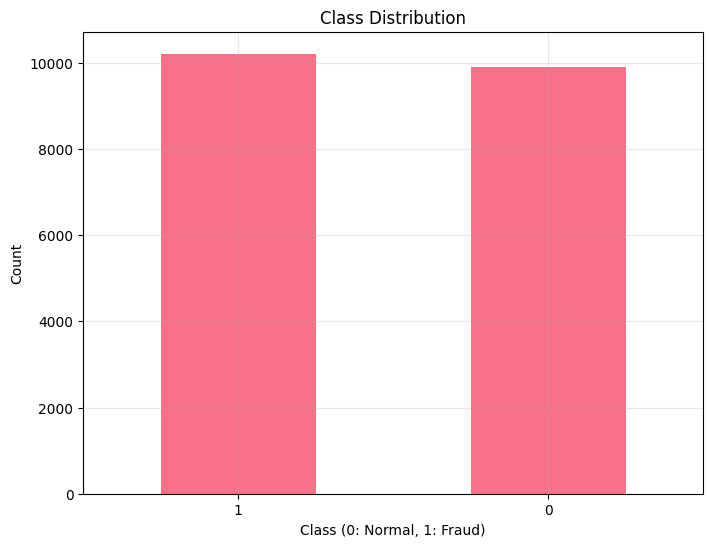

In [3]:
# Basic dataset information
print(f"Dataset Overview")
print(f"Shape: {df.shape}")
print(f"Fraud cases: {df['label'].sum()} ({df['label'].mean():.2%})")
print(f"Non-fraud cases: {(df['label'] == 0).sum()} ({(df['label'] == 0).mean():.2%})")
print(f"Missing values: {df.isnull().sum().sum()}")

# Class distribution
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
# Basic statistics
print("Basic Statistics:")
df.describe()

Basic Statistics:


,total_edits,num_edit_sessions,avg_categories_per_edit,revert_rate,unique_pages,avg_stiki_score,cluebot_revert_count,edit_frequency,night_edits,day_edits,weekend_edits,page_category_diversity,label
count,2.010600e+04,2.010600e+04,2.010600e+04,2.010600e+04,2.010600e+04,2.010600e+04,2.010600e+04,2.010600e+04,2.010600e+04,2.010600e+04,2.010600e+04,2.010600e+04,20106.000000
mean,1.413593e-18,1.413593e-18,3.746023e-17,2.450818e-16,5.124276e-18,-1.378254e-16,4.523499e-17,-3.533984e-19,3.533984e-18,1.395924e-17,-8.481561e-18,5.124276e-18,0.507759
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,0.499952
min,-3.312104e-01,-3.312104e-01,-9.375854e-01,-1.118935e+00,-3.618058e-01,-9.282049e-01,-4.913001e-01,-2.066833e-01,-3.043165e-01,-3.044813e-01,-2.690898e-01,-3.618058e-01,0.000000
25%,-2.904754e-01,-2.904754e-01,-7.270389e-01,-1.118935e+00,-3.219281e-01,-9.142957e-01,-4.913001e-01,-2.066066e-01,-3.043165e-01,-3.044813e-01,-2.690898e-01,-3.219281e-01,0.000000
50%,-2.497404e-01,-2.497404e-01,-2.566609e-01,-2.533456e-03,-2.288800e-01,-3.587576e-01,-4.913001e-01,-2.057435e-01,-2.152855e-01,-2.265436e-01,-2.690898e-01,-2.288800e-01,1.000000
75%,-1.411137e-01,-1.411137e-01,3.983450e-01,1.113868e+00,-3.613745e-02,6.206995e-01,1.849102e-01,-1.459044e-01,-1.039968e-01,-9.664749e-02,-9.979114e-02,-3.613745e-02,1.000000
max,3.499960e+01,3.499960e+01,1.207166e+01,1.113868e+00,2.246157e+01,4.420386e+00,1.506154e+01,8.122556e+01,4.554664e+01,1.476347e+01,3.532595e+01,2.246157e+01,1.000000


## 3. Feature Distribution Analysis

In [5]:
# Summary statistics by class
print(" Feature Statistics by Class:")
summary = df.groupby("label").agg(['mean', 'std', 'median']).round(3)
summary

 Feature Statistics by Class:


total_edits               num_edit_sessions                \
             mean    std median              mean    std median   
label                                                             
0           0.203  1.296 -0.223             0.203  1.296 -0.223   
1          -0.196  0.513 -0.263            -0.196  0.513 -0.263   

      avg_categories_per_edit               revert_rate  ... night_edits  \
                         mean    std median        mean  ...      median   
label                                                    ...               
0                      -0.480  0.583 -0.656      -0.902  ...      -0.215   
1                       0.465  1.096  0.232       0.875  ...      -0.238   

      day_edits               weekend_edits                \
           mean    std median          mean    std median   
label                                                       
0         0.192  1.346 -0.201         0.166  1.291 -0.269   
1        -0.186  0.379 -0.279        -0.161  0.549 -0.269   

      page_category_diversity                
                         mean    std median  
label                                        
0                       0.071  1.321 -0.282  
1                      -0.069  0.519 -0.182  

[2 rows x 36 columns]

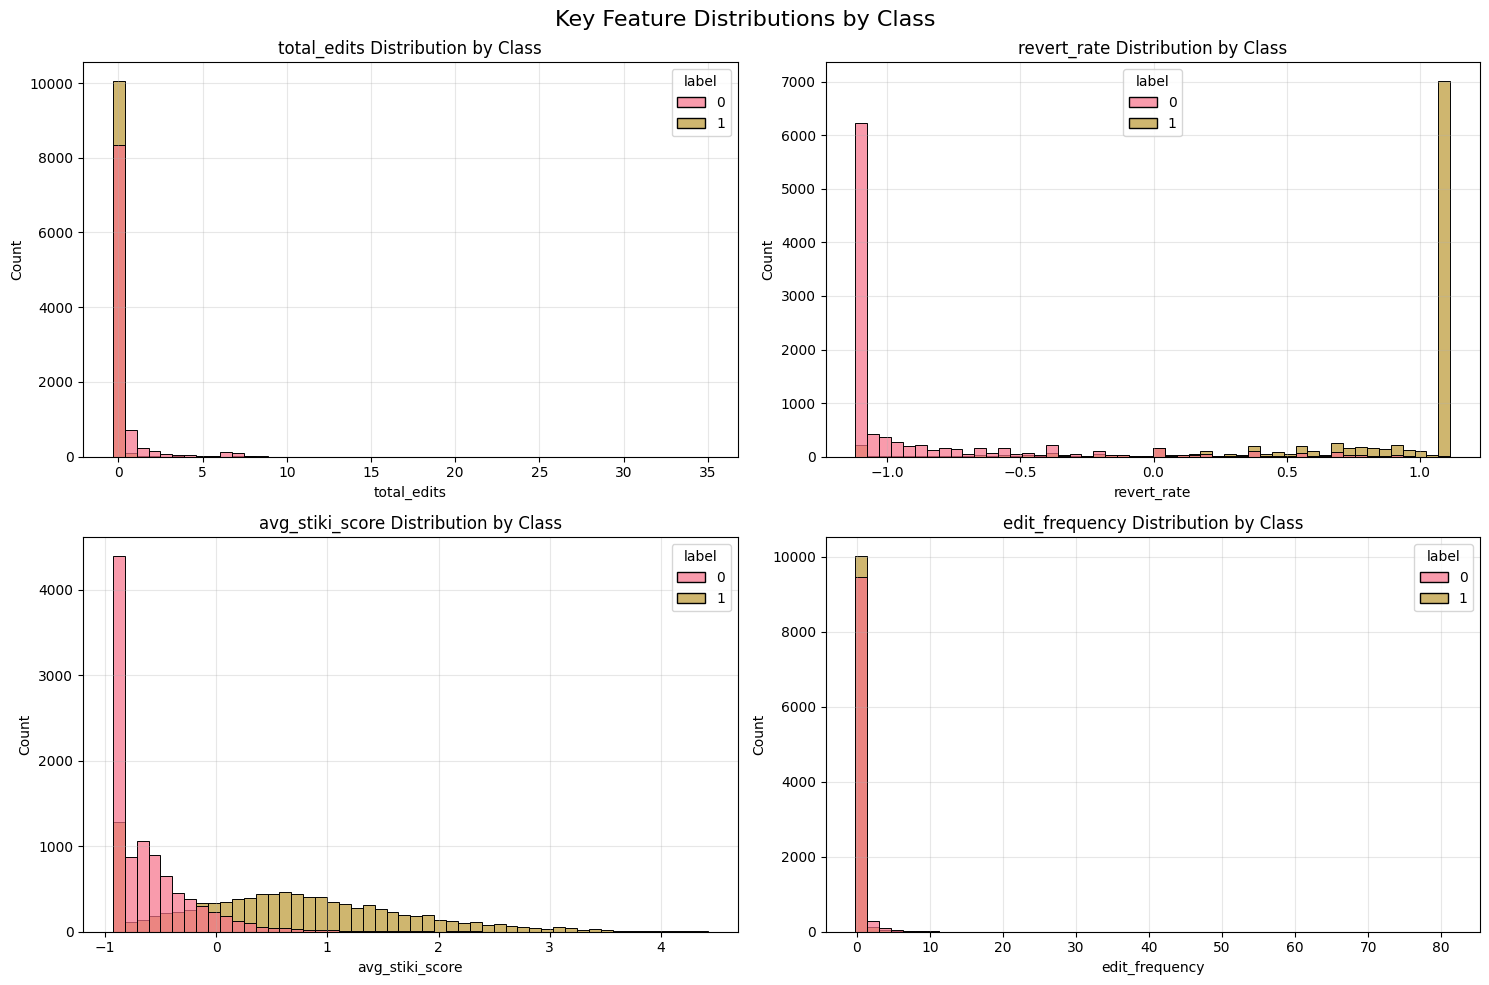

In [6]:
# Distribution plots for key features
key_features = ['total_edits', 'revert_rate', 'avg_stiki_score', 'edit_frequency']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.histplot(data=df, x=feature, hue='label', bins=50, alpha=0.7, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Class')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Key Feature Distributions by Class', fontsize=16)
plt.tight_layout()
plt.show()

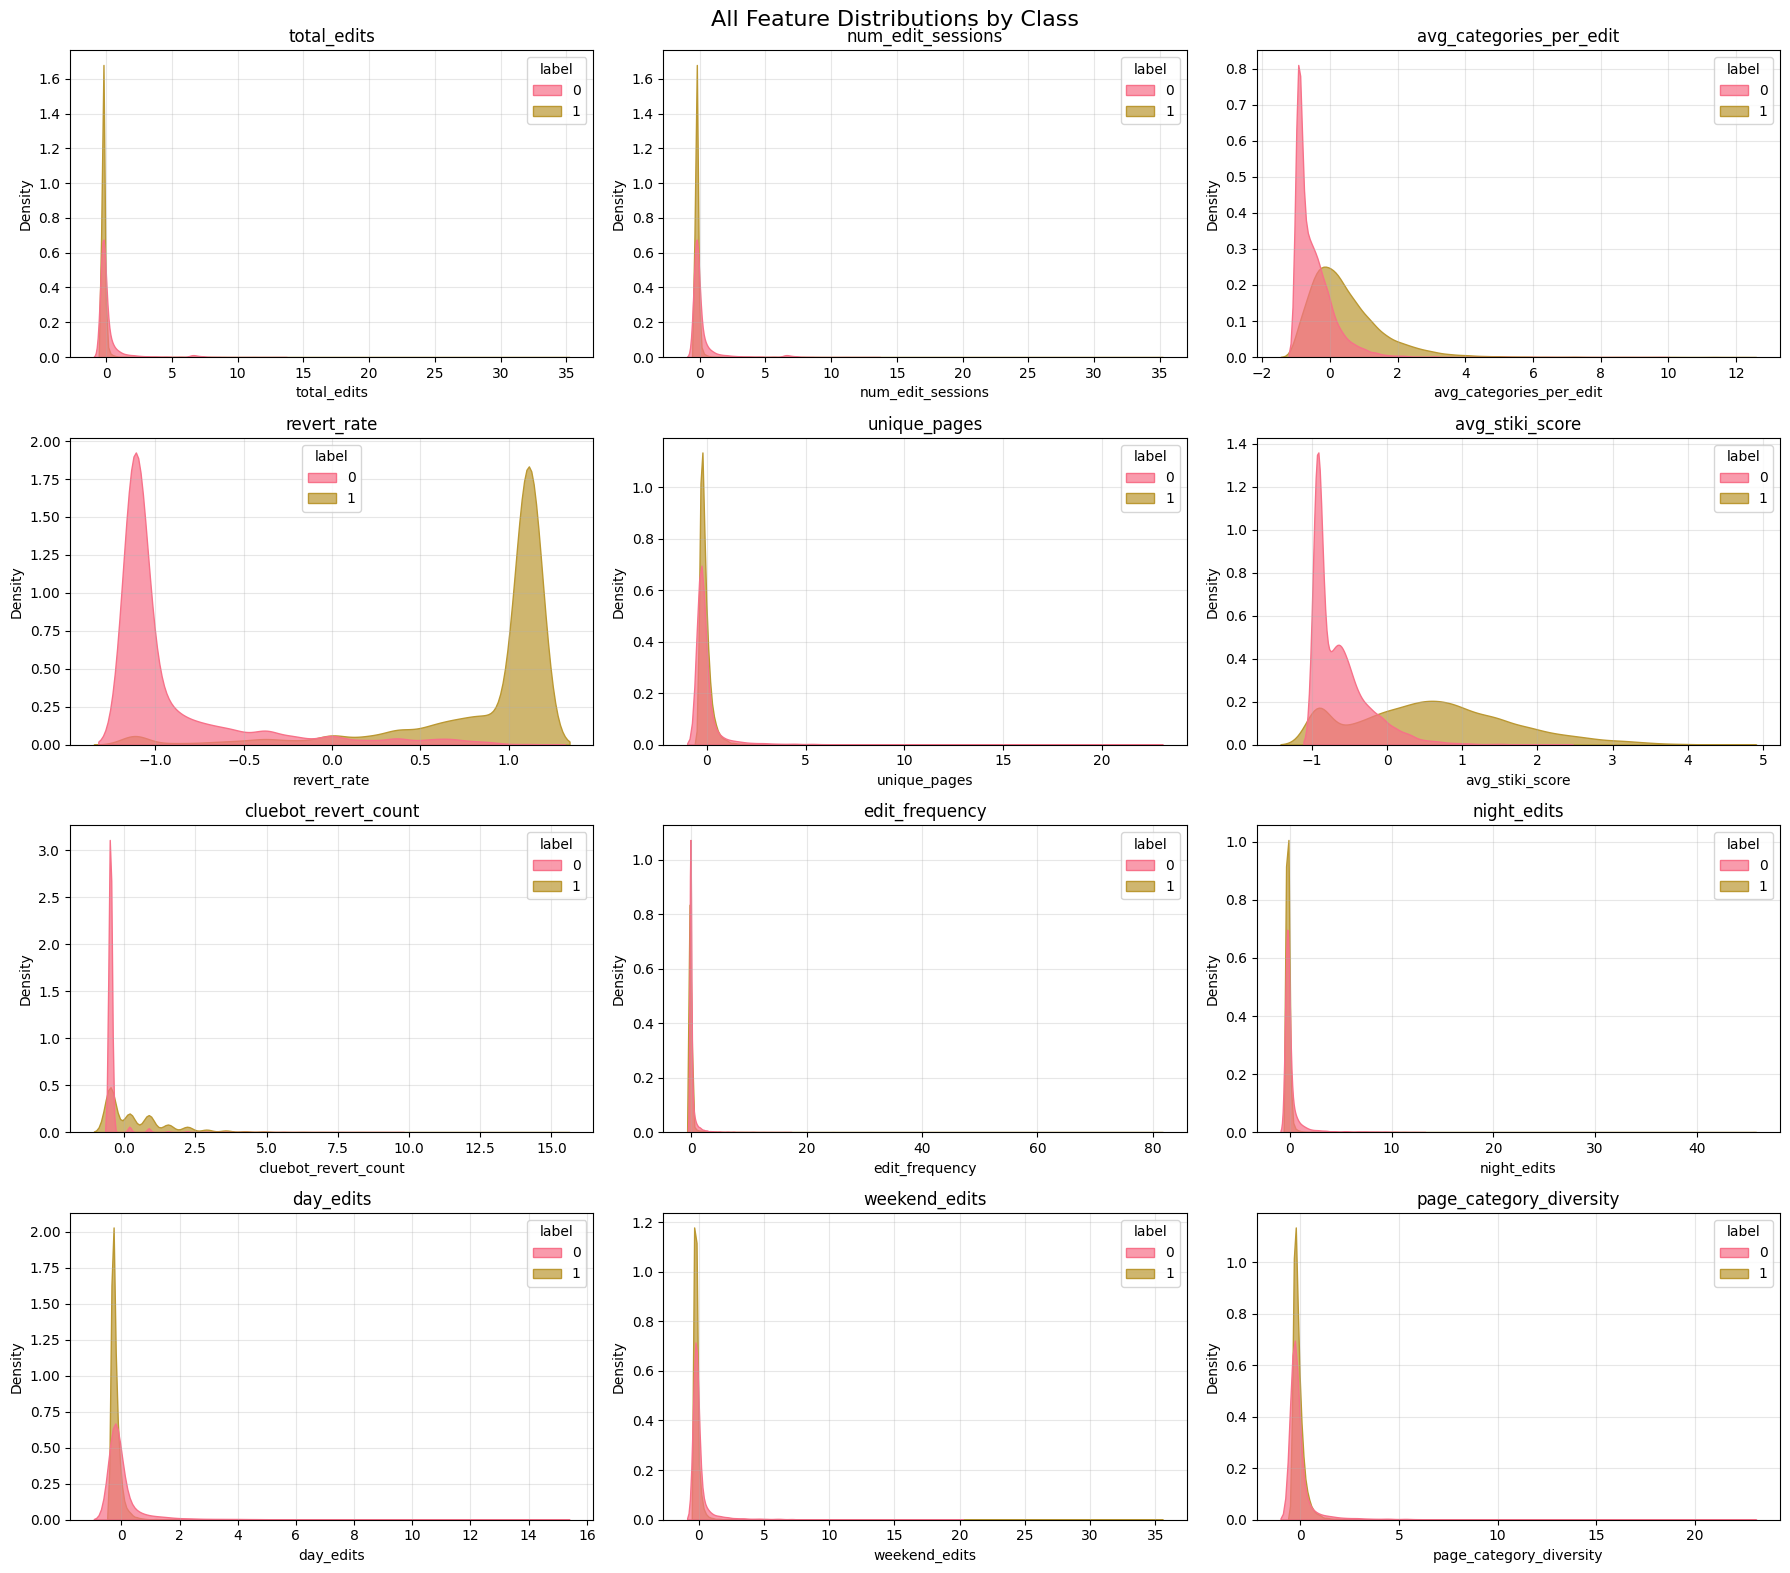

In [7]:
# Distribution plots for all features
X = df.drop(columns='label')
n_features = len(X.columns)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()

for i, feature in enumerate(X.columns):
    sns.kdeplot(data=df, x=feature, hue='label', fill=True, alpha=0.7, ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].grid(True, alpha=0.3)

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('All Feature Distributions by Class', fontsize=16)
plt.tight_layout()
plt.show()

## 4. Correlation Analysis

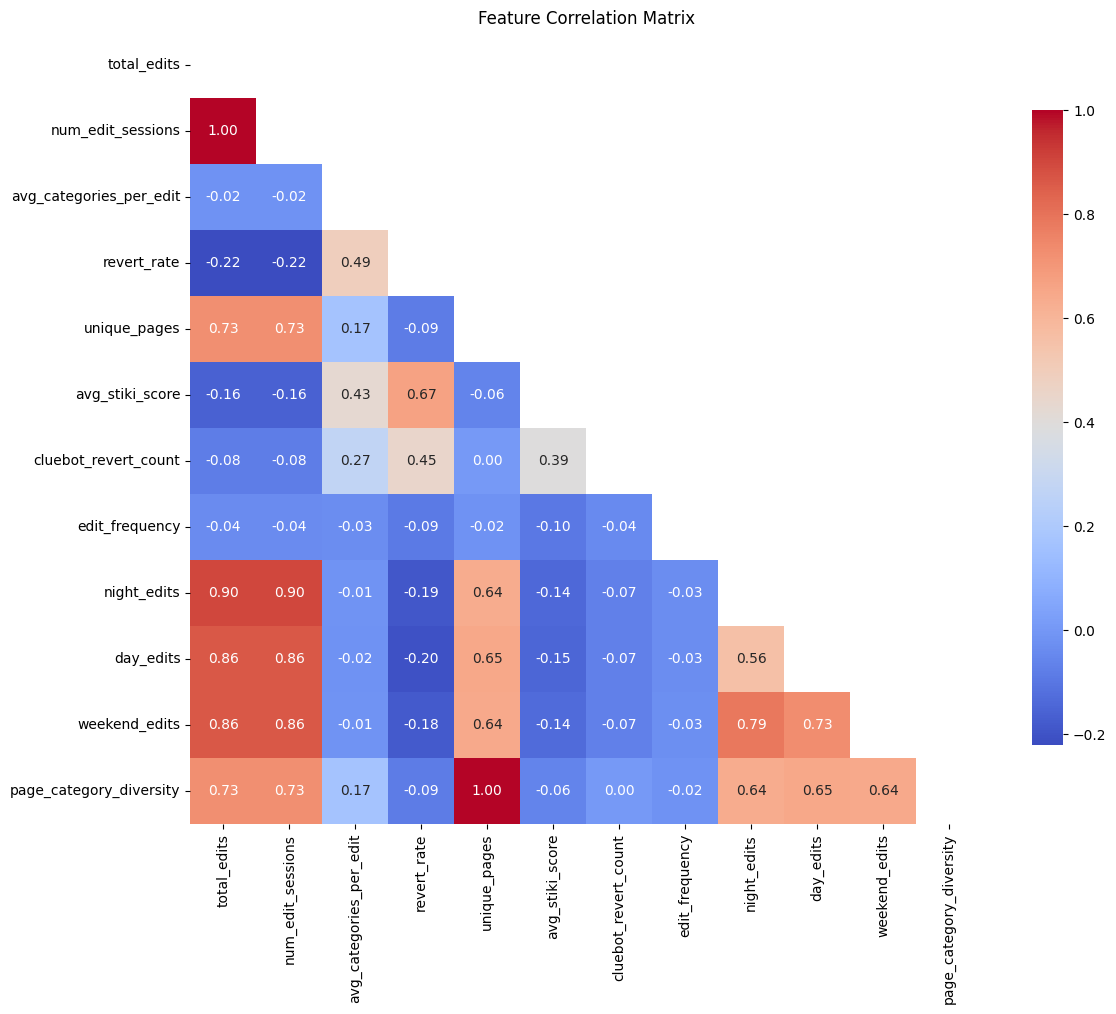

In [8]:
# Feature correlation matrix
# X['label'] = y_train
plt.figure(figsize=(12, 10))
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [9]:
# Find highly correlated pairs
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.7:
            high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

if high_corr:
    print(" Highly Correlated Features (|r| > 0.7):")
    for feat1, feat2, corr_val in high_corr:
        print(f"  {feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("No highly correlated features found (|r| > 0.7)")

 Highly Correlated Features (|r| > 0.7):
  total_edits <-> num_edit_sessions: 1.000
  total_edits <-> unique_pages: 0.727
  total_edits <-> night_edits: 0.901
  total_edits <-> day_edits: 0.862
  total_edits <-> weekend_edits: 0.864
  total_edits <-> page_category_diversity: 0.727
  num_edit_sessions <-> unique_pages: 0.727
  num_edit_sessions <-> night_edits: 0.901
  num_edit_sessions <-> day_edits: 0.862
  num_edit_sessions <-> weekend_edits: 0.864
  num_edit_sessions <-> page_category_diversity: 0.727
  unique_pages <-> page_category_diversity: 1.000
  night_edits <-> weekend_edits: 0.790
  day_edits <-> weekend_edits: 0.731


## 5. Feature Importance Analysis

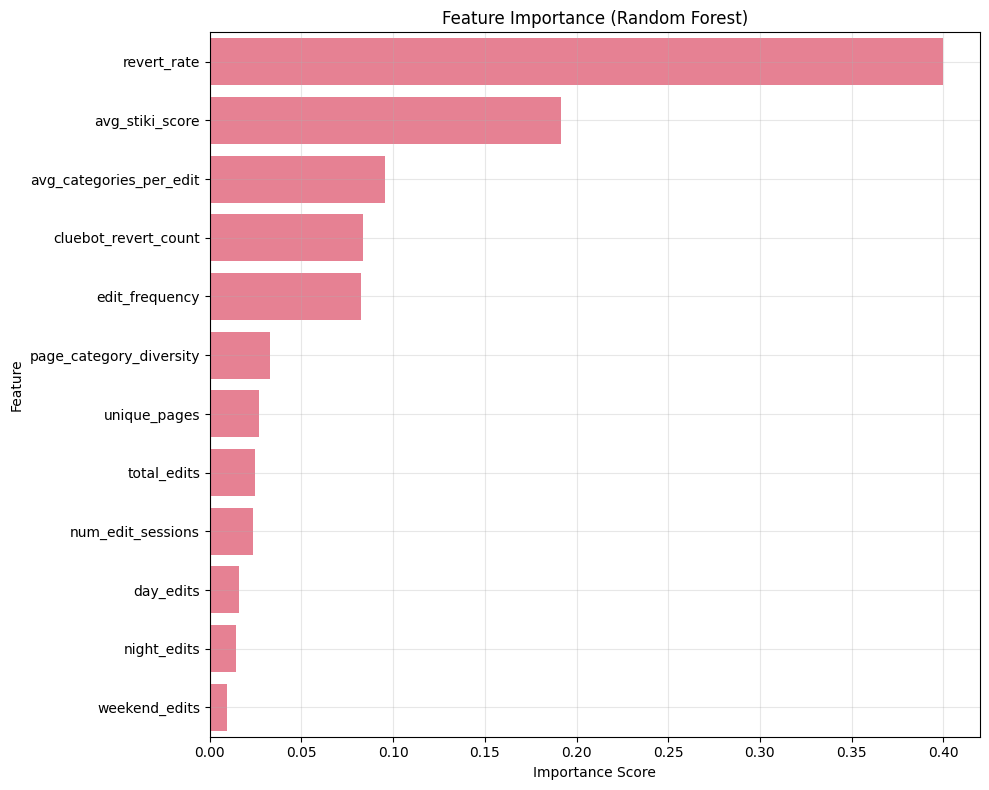

⭐ Top 5 Most Important Features:
  1. revert_rate: 0.400
  2. avg_stiki_score: 0.192
  3. avg_categories_per_edit: 0.095
  4. cluebot_revert_count: 0.084
  5. edit_frequency: 0.083

🎯 Random Forest Validation Accuracy: 0.944


In [10]:
# Train Random Forest for feature importance
y = df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, y='Feature', x='Importance')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("⭐ Top 5 Most Important Features:")
for i, (_, row) in enumerate(importance_df.head().iterrows()):
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.3f}")

val_accuracy = rf.score(X_val, y_val)
print(f"\n🎯 Random Forest Validation Accuracy: {val_accuracy:.3f}")

## 6. Statistical Tests

In [11]:
# Statistical tests for significant differences between classes
fraud_data = df[df['label'] == 1]
normal_data = df[df['label'] == 0]

print(" Statistical Tests (p-values for class differences):")
print("*** p < 0.001, ** p < 0.01, * p < 0.05")

significant_features = []
test_results = []

for feature in X.columns:
    fraud_values = fraud_data[feature]
    normal_values = normal_data[feature]
    
    # Mann-Whitney U test (non-parametric)
    stat, p_value = stats.mannwhitneyu(fraud_values, normal_values, alternative='two-sided')
    
    if p_value < 0.001:
        significance = "***"
        significant_features.append(feature)
    elif p_value < 0.01:
        significance = "**"
        significant_features.append(feature)
    elif p_value < 0.05:
        significance = "*"
        significant_features.append(feature)
    else:
        significance = ""
        
    test_results.append({
        'Feature': feature,
        'p_value': p_value,
        'significance': significance
    })
    
    print(f"  {feature}: {p_value:.2e} {significance}")

print(f"\n📊 {len(significant_features)} features show significant differences between classes")

 Statistical Tests (p-values for class differences):
*** p < 0.001, ** p < 0.01, * p < 0.05
  total_edits: 1.42e-154 ***
  num_edit_sessions: 1.42e-154 ***
  avg_categories_per_edit: 0.00e+00 ***
  revert_rate: 0.00e+00 ***
  unique_pages: 1.92e-271 ***
  avg_stiki_score: 0.00e+00 ***
  cluebot_revert_count: 0.00e+00 ***
  edit_frequency: 0.00e+00 ***
  night_edits: 8.72e-62 ***
  day_edits: 0.00e+00 ***
  weekend_edits: 5.77e-250 ***
  page_category_diversity: 1.92e-271 ***

📊 12 features show significant differences between classes


## 7. Outlier Analysis

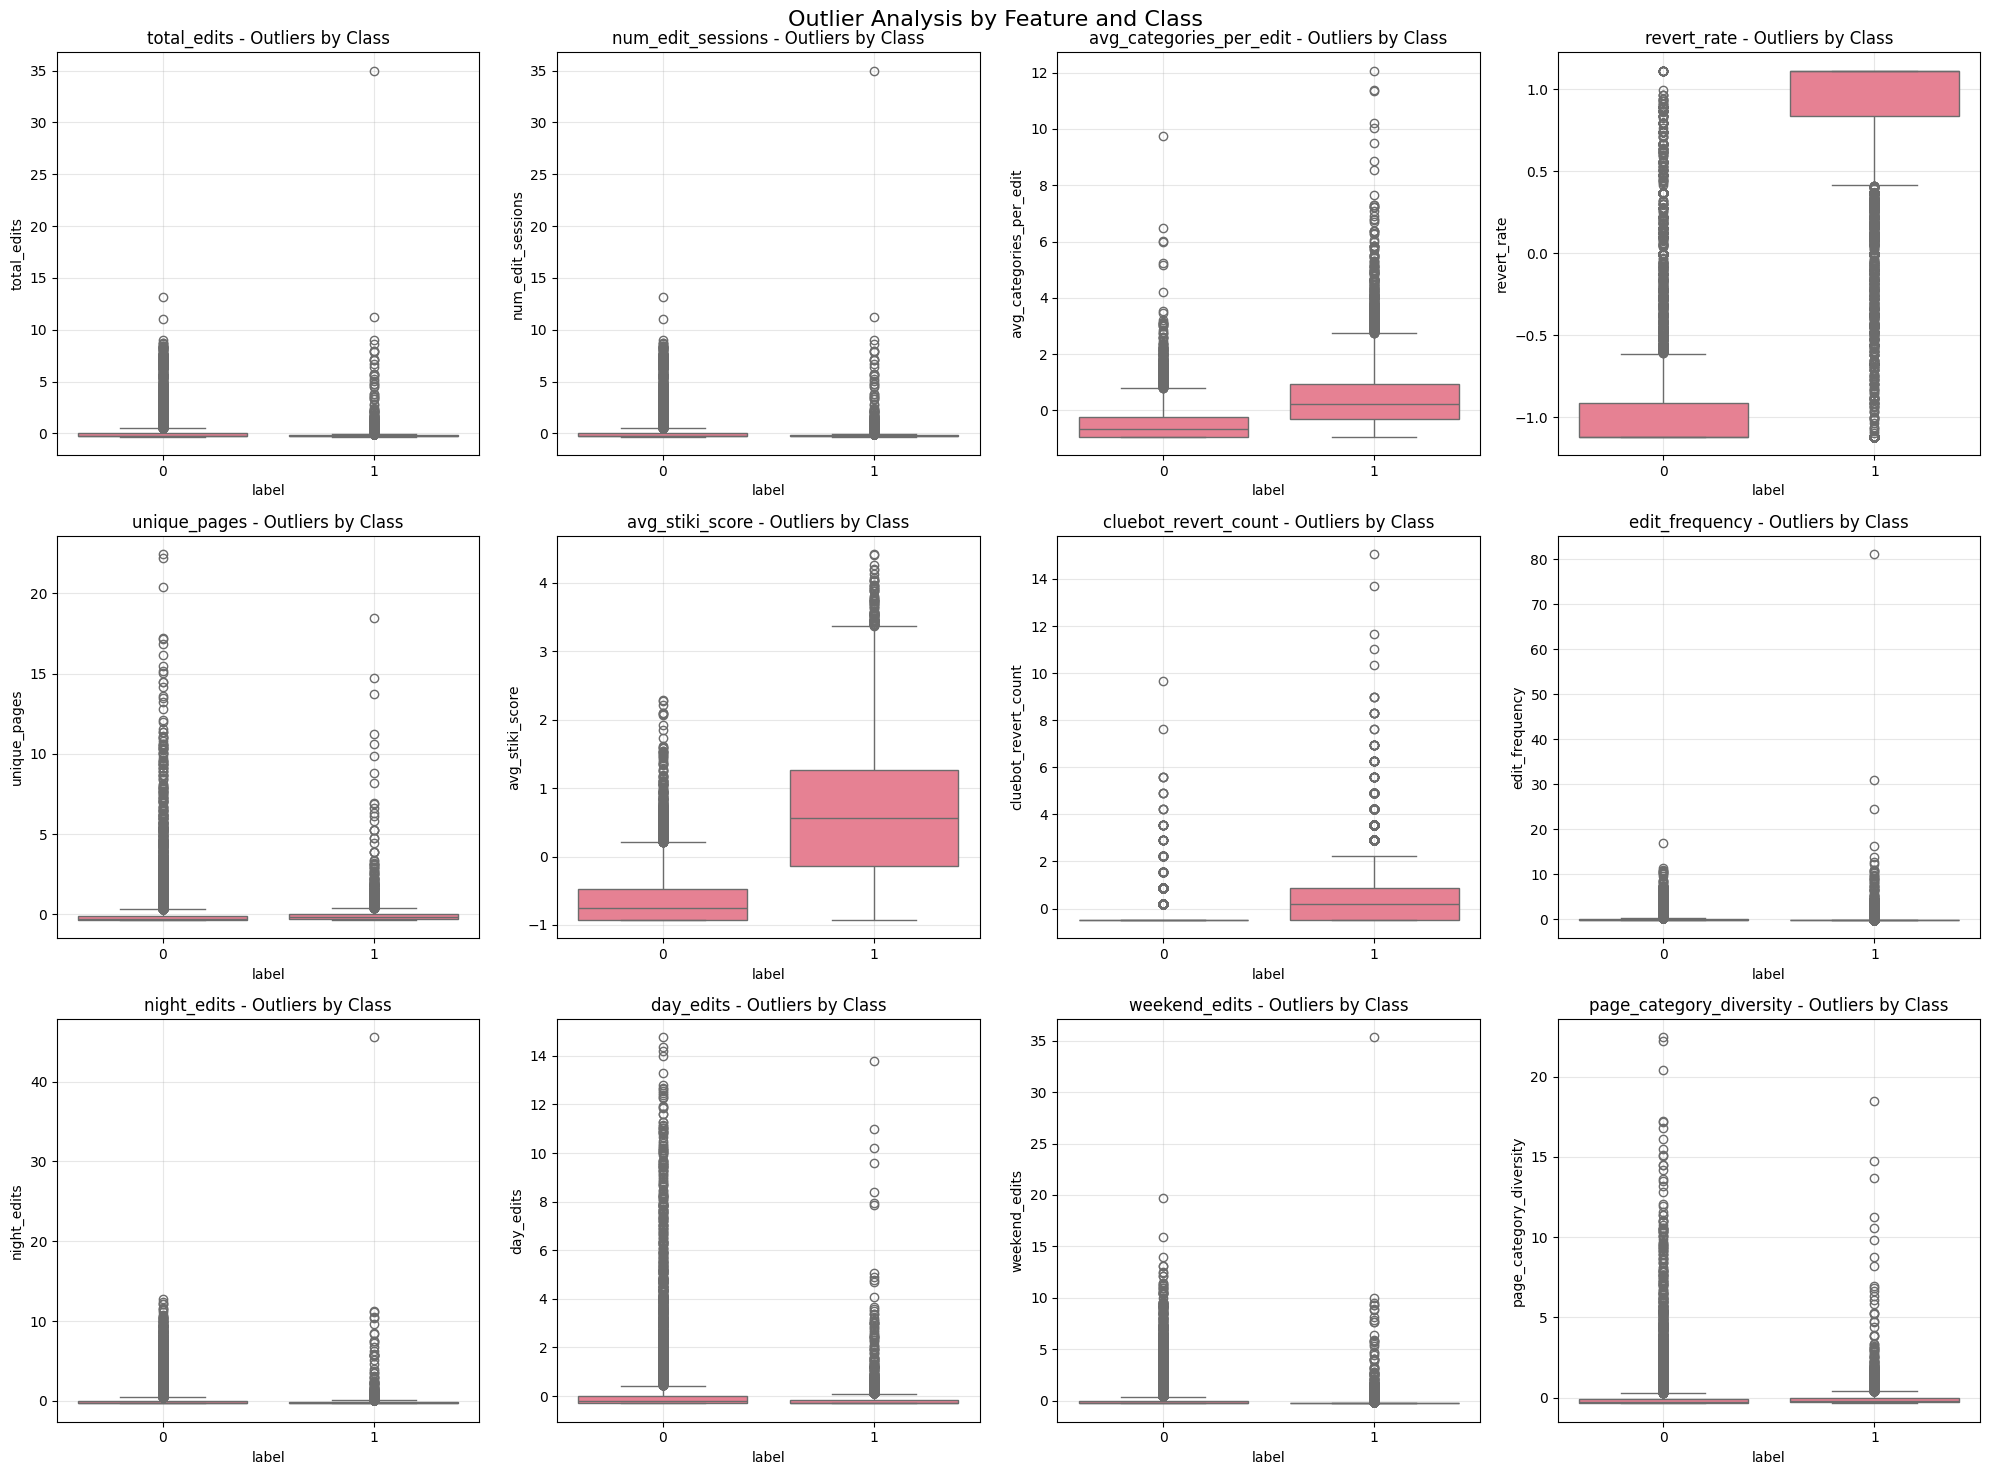

In [12]:
# Box plots for outlier detection
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(X.columns):
    sns.boxplot(data=df, x='label', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} - Outliers by Class')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Outlier Analysis by Feature and Class', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Summary and Key Insights

In [13]:
print("EDA Summary:")
print(f"\n1. Dataset Overview:")
print(f"   - Total samples: {len(df)}")
print(f"   - Features: {len(X.columns)}")
print(f"   - Class imbalance: {df['label'].mean():.2%} fraud cases")

print(f"\n2. Feature Importance (Top 3):")
for i, (_, row) in enumerate(importance_df.head(3).iterrows()):
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.3f}")

print(f"\n3. Statistical Significance:")
print(f"   - {len(significant_features)} features show significant class differences")
print(f"   - Most significant: {[f for f in significant_features[:3]]}")

print(f"\n4. Model Performance:")
print(f"   - Random Forest validation accuracy: {val_accuracy:.3f}")

print(f"\n EDA Complete!")

EDA Summary:

1. Dataset Overview:
   - Total samples: 20106
   - Features: 12
   - Class imbalance: 50.78% fraud cases

2. Feature Importance (Top 3):
   1. revert_rate: 0.400
   2. avg_stiki_score: 0.192
   3. avg_categories_per_edit: 0.095

3. Statistical Significance:
   - 12 features show significant class differences
   - Most significant: ['total_edits', 'num_edit_sessions', 'avg_categories_per_edit']

4. Model Performance:
   - Random Forest validation accuracy: 0.944

 EDA Complete!
